### Hadoop3.3 + Spark3.0 + IPython3.7 机器学习与大数据实战
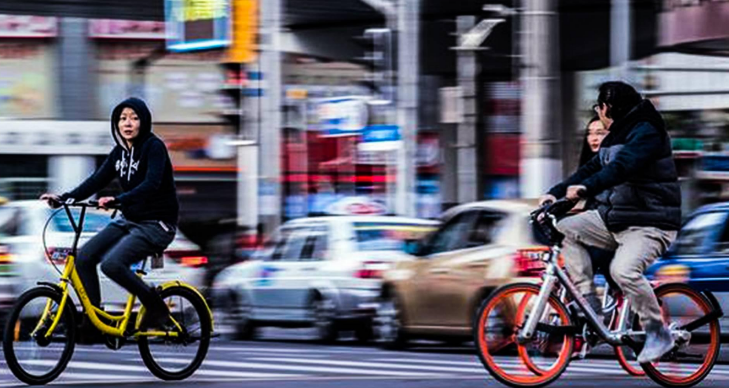
## <center>共享单车流量预测系统 >>> 基于 Spark ML Pipeline 回归分析</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.12.23</center>  
  
<font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>   
  
<font color=blue><center>项目源代码、数据、自定义函数已上传GitHub：</center></font>   
    
<font color=blue><center>https://github.com/lotbear/Python-Financial-investment-strategy</center></font>

### 流程式机器学习  Spark ML Pipeline

ML Pipeline 的原理是，将机器学习的每一个阶段（如数据清洗、特征工程、模型训练、模型预测等）集合成一个固定的流程，方便不断重复调用。

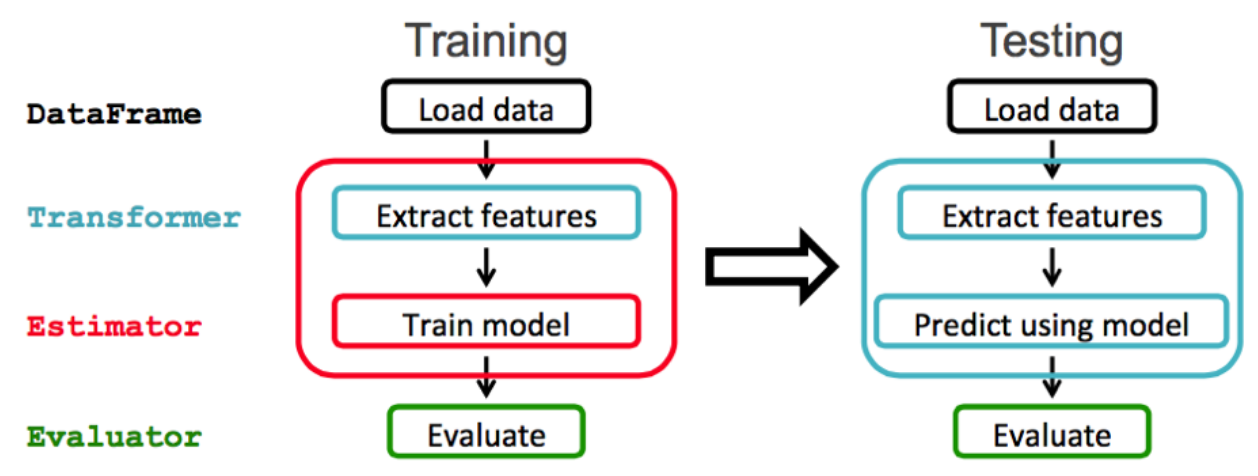

本例中，我们将 Pipeline 划分为 3 个阶段，前 2 个阶段是数据处理，第 3 个阶段为模型拟合：   

1》 VectorAssembler : 将所有特征向量整合在一起；   

2》 VectorIndexer : 将数值型数据进一步区分，若取值种类 <= maxCategories，则被分为类别数据，否则为数值数据；     

3》 DesionTreeClassifier : 用决策树模型进行回归训练。

### 回归分析项目：共享单车流量预测系统

#### <font color=blue>>>> 通过算法建模，预测不同天气、季节、节假日等情况下，共享单车的实时租用数量。</font>         

该项目数据由 加州大学尔湾分校（University og California Irvine）提供

网址：http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

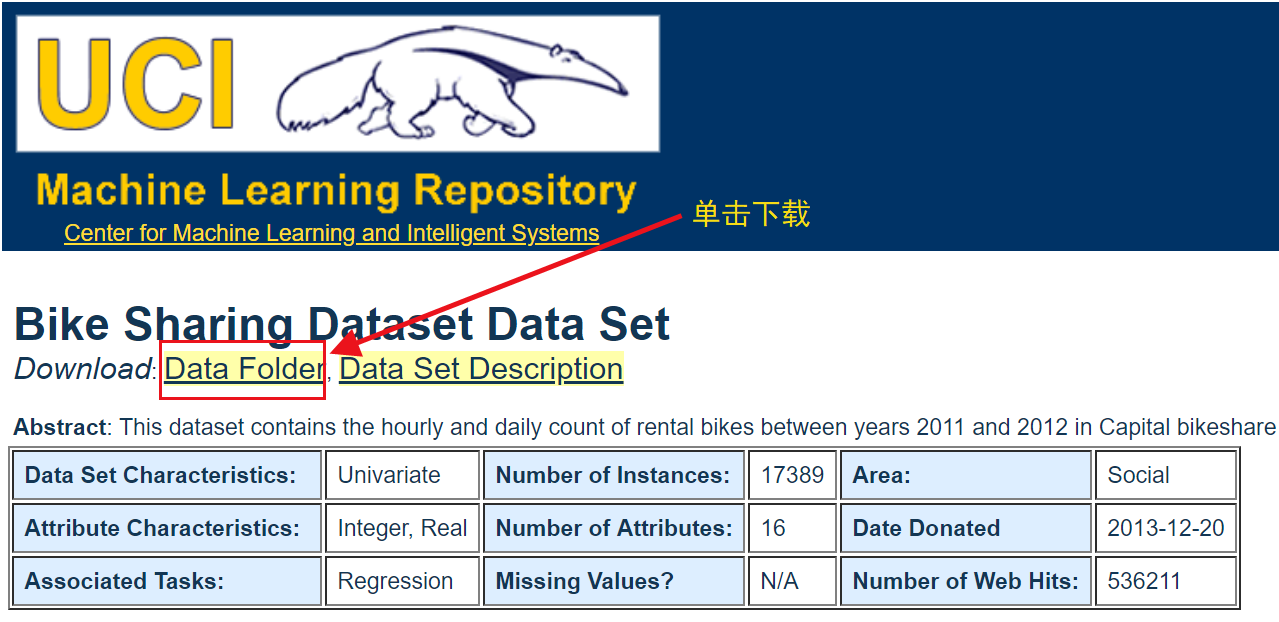

### >>> 数据基本情况：
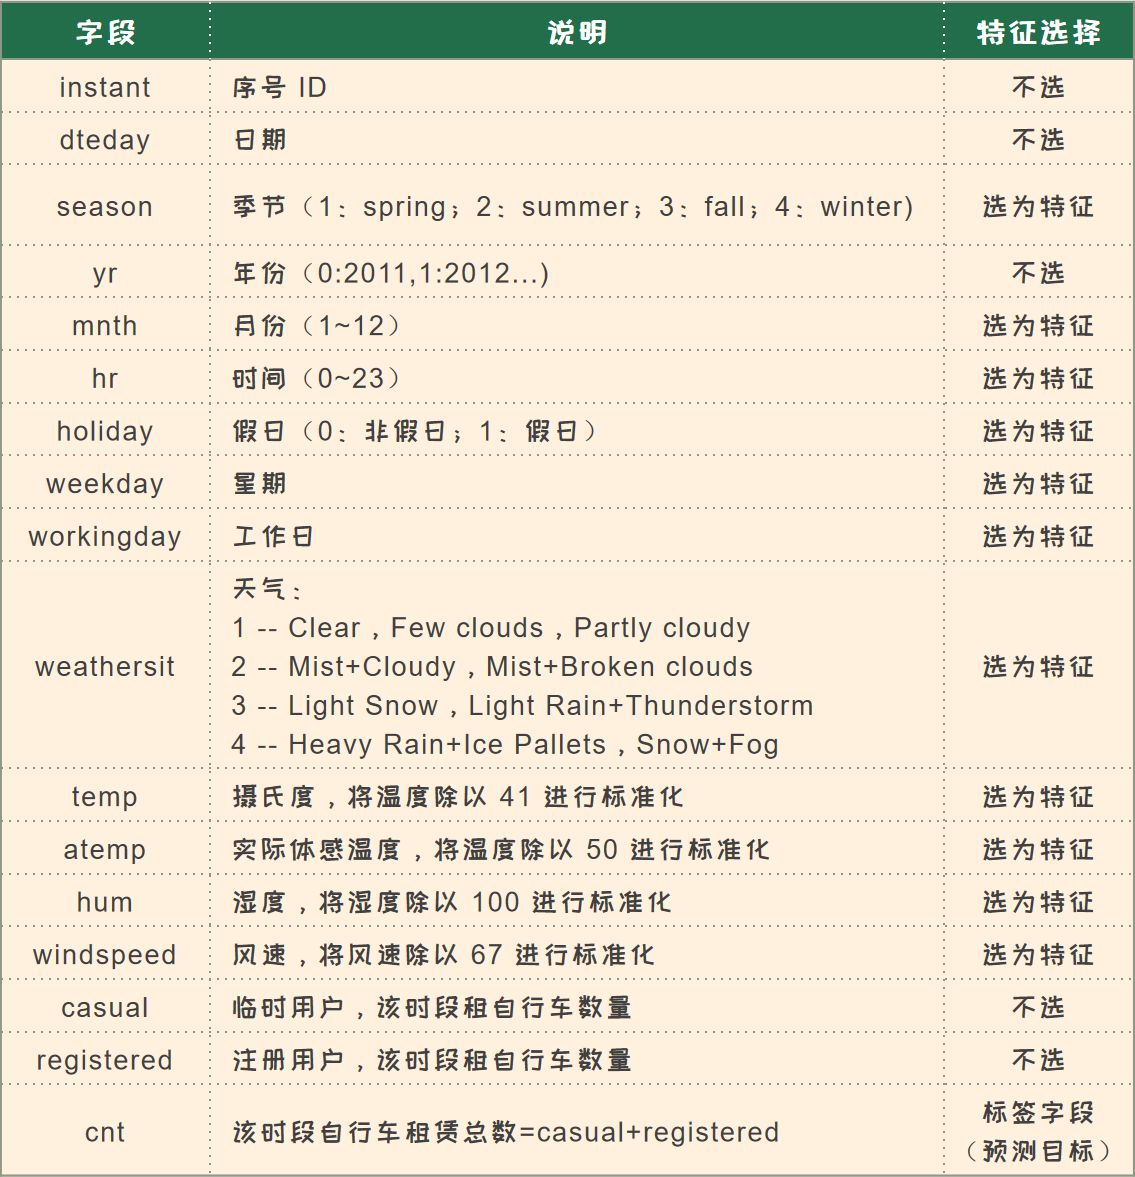

### >>> 算法实战     

### 第一步：数据上传 Hadoop-HDFS 分布式平台后，用 Saprk 命令读取 / 查看 / 清洗。

In [1]:
# 查看 Spark 的运行模式，本次算法基于 Hadoop-yarn 模式
# 实现 4 台虚拟机同步进行的分布式运算
print('查看 Spark 的运行模式：',str(sc.master))

查看 Spark 的运行模式： yarn


In [2]:
# 设置全局数据集的路径
# 若 sc.master 查看显示的运行模式为 "local",则使用本地数据集
# 若 sc.master 查看显示的运行模式为其他，如 "yarn"，"spark://master:7077"(Standalone模式)
# 则选择 HDFS 上的数据集
global Path    
if sc.master[0:5]=="local" :
   Path="/home/lotbear/Big-Data/"
else:   
   Path="hdfs://master:9000/user/lotbear/data/"

Spark ML 机器学习 API 处理的数据格式为 DataFrame

因此选择用 sqlContext.read 导入文件，并创建 row_df 为 DataFrame 格式

In [3]:
hour_df= spark.read.format("csv").option("header", "true").load(Path+"bikehour.csv")
print('样本数据总量：',hour_df.count())

样本数据总量： 17379


In [4]:
print('查看变量名称：')
print(hour_df.columns)

查看变量名称：
['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


In [5]:
# 删除部分不需要的特征变量
hour_df=hour_df.drop("instant").drop("dteday") \
                            .drop('yr').drop("casual").drop("registered")

In [6]:
# 将数据类型改为 double
from pyspark.sql.functions import col  
hour_df= hour_df.select([ col(column).cast("double").alias(column) 
                                          for column in hour_df.columns])

In [7]:
# 查看数据的 Schema(字段名 + 数据类型)
hour_df.printSchema()

root
 |-- season: double (nullable = true)
 |-- mnth: double (nullable = true)
 |-- hr: double (nullable = true)
 |-- holiday: double (nullable = true)
 |-- weekday: double (nullable = true)
 |-- workingday: double (nullable = true)
 |-- weathersit: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cnt: double (nullable = true)



In [8]:
print('查看清洗后的数据前 5 行：')
hour_df.show(5)

查看清洗后的数据前 5 行：
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+
|season|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed| cnt|
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+
|   1.0| 1.0|0.0|    0.0|    6.0|       0.0|       1.0|0.24|0.2879|0.81|      0.0|16.0|
|   1.0| 1.0|1.0|    0.0|    6.0|       0.0|       1.0|0.22|0.2727| 0.8|      0.0|40.0|
|   1.0| 1.0|2.0|    0.0|    6.0|       0.0|       1.0|0.22|0.2727| 0.8|      0.0|32.0|
|   1.0| 1.0|3.0|    0.0|    6.0|       0.0|       1.0|0.24|0.2879|0.75|      0.0|13.0|
|   1.0| 1.0|4.0|    0.0|    6.0|       0.0|       1.0|0.24|0.2879|0.75|      0.0| 1.0|
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+
only showing top 5 rows



In [9]:
# 将训练集数据按 7：3 分为 train_df，test_df 两个数据集
train_df, test_df = hour_df.randomSplit([0.7, 0.3])
train_df.cache()
test_df.cache()

DataFrame[season: double, mnth: double, hr: double, holiday: double, weekday: double, workingday: double, weathersit: double, temp: double, atemp: double, hum: double, windspeed: double, cnt: double]

### 第二步：使用 ML Pipeline 流程组件，进行阶段模块设计

导入相关工具包 ：   

<font color=red>特征工程：</font> <font color=blue>VectorAssembler --> VectorIndexer</font>   

<font color=red>分类模型：</font> <font color=blue>DecisionTreeClassifier</font>

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorIndexer,VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor

In [11]:
print('查看特征变量名称:')
featuresCols = hour_df.columns[:-1]
print(featuresCols)

查看特征变量名称:
['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [12]:
vectorAssembler = VectorAssembler(inputCols=featuresCols, outputCol="aFeatures")
vectorIndexer = VectorIndexer(inputCol="aFeatures", outputCol="features", maxCategories=24)
dt = DecisionTreeRegressor(labelCol="cnt",featuresCol= 'features')
dt_pipeline = Pipeline(stages=[vectorAssembler,vectorIndexer ,dt])

In [13]:
dt_pipeline.getStages()

[VectorAssembler_88a0a1abcc67,
 VectorIndexer_b674f6aa747f,
 DecisionTreeRegressor_2f6fdb72c3dc]

### 第三步：使用 Pipeline 进行数据处理与训练

In [14]:
# 用训练集数据建立模型
dt_pipelineModel = dt_pipeline.fit(train_df)
dt_pipelineModel.stages[2]

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2f6fdb72c3dc, depth=5, numNodes=63, numFeatures=11

In [15]:
# 查看训练好的模型的前 500 字节的规则描述
print(dt_pipelineModel.stages[2].toDebugString[:500])

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2f6fdb72c3dc, depth=5, numNodes=63, numFeatures=11
  If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,22.0,23.0})
   If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0})
    If (feature 2 in {2.0,3.0,4.0,5.0})
     If (feature 4 in {1.0,2.0,3.0,4.0,5.0})
      If (feature 2 in {2.0,3.0,4.0})
       Predict: 6.6215177713736795
      Else (feature 2 not in {2.0,3.0,4.0})
       Predict: 24.46175637393768
     Else (feature 4 not in {1.0,2.0,3.0,4.0,5.0})



### 第四步：使用 PipelineModel 进行预测

In [16]:
# 用模型预测 测试集数据
predicted_df=dt_pipelineModel.transform(test_df)
print(predicted_df.columns)

['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'aFeatures', 'features', 'prediction']


In [17]:
print('查看不同特征变量 + 真实')
predicted_df.select('season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', \
                     'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt','prediction').show(10)

查看不同特征变量 + 真实
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+-----------------+
|season|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed| cnt|       prediction|
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+-----------------+
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.04|0.0758|0.57|   0.1045|22.0|58.38414634146341|
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.16|0.1364| 0.8|   0.2985|52.0|58.38414634146341|
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.26| 0.303|0.56|      0.0|39.0|58.38414634146341|
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       2.0|0.46|0.4545|0.88|   0.2985|17.0|58.38414634146341|
|   1.0| 1.0|0.0|    0.0|    1.0|       1.0|       1.0|0.12|0.1212| 0.5|   0.2836| 5.0|         38.09375|
|   1.0| 1.0|0.0|    0.0|    1.0|       1.0|       2.0|0.24|0.2273|0.65|   0.2239| 7.0|         38.09375|
|   1.0| 1.0|0.0|    0.0|    2.0

### 第五步：评估模型的准确率

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

In [19]:
evaluator = RegressionEvaluator(labelCol='cnt',predictionCol='prediction',metricName="rmse")

In [20]:
predicted_df=dt_pipelineModel.transform(test_df)
rmse = evaluator.evaluate(predicted_df)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 96.18788425533188


### 第六步：使用 TrainValidation 进行模型评估，寻找最优参数  

先用网格搜素方式 ParamGridBuilder 对模型中的多个参数进行赋值

再用 TrainValidationSplit 对各个参数组合得出的指标 AUC 进行排序，寻找最优参数指标

In [21]:
from pyspark.ml.tuning import ParamGridBuilder,TrainValidationSplit
paramGrid = ParamGridBuilder()\
  .addGrid(dt.maxDepth, [ 5,10,15,25])\
  .addGrid(dt.maxBins, [25,35,45,50])\
  .build()

In [22]:
tvs = TrainValidationSplit(estimator=dt,evaluator=evaluator,
                  estimatorParamMaps=paramGrid,trainRatio=0.8)
tvs_pipeline = Pipeline(stages=[vectorAssembler,vectorIndexer ,tvs])
tvs_pipelineModel =tvs_pipeline.fit(train_df)

bestModel=tvs_pipelineModel.stages[2].bestModel
print(bestModel.toDebugString[:500])

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2f6fdb72c3dc, depth=10, numNodes=1829, numFeatures=11
  If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,22.0,23.0})
   If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0})
    If (feature 2 in {2.0,3.0,4.0,5.0})
     If (feature 4 in {1.0,2.0,3.0,4.0,5.0})
      If (feature 2 in {2.0,3.0,4.0})
       If (feature 2 in {3.0,4.0})
        If (feature 1 in {0.0,1.0,2.0,3.0,11.0})
         If (feature 0 in {0.0})
          If (feature 7 <= 0.35)
           


In [23]:
predictions = tvs_pipelineModel.transform(test_df)
rmse= evaluator.evaluate(predictions)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 80.66477646793759


### 第七步：使用 crossValidation 进行模型评估，寻找最优参数

进一步，可用 crossValidation 交叉验证法，对数据进行 K-Fold 训练及验证，得到更稳定的模型

In [24]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=dt, evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, numFolds=3)

cv_pipeline = Pipeline(stages=[vectorAssembler,vectorIndexer ,cv])
cv_pipelineModel = cv_pipeline.fit(train_df)
bestModel=cv_pipelineModel.stages[2].bestModel
bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2f6fdb72c3dc, depth=10, numNodes=1829, numFeatures=11

In [25]:
print(bestModel.toDebugString[:500])

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2f6fdb72c3dc, depth=10, numNodes=1829, numFeatures=11
  If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,22.0,23.0})
   If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0})
    If (feature 2 in {2.0,3.0,4.0,5.0})
     If (feature 4 in {1.0,2.0,3.0,4.0,5.0})
      If (feature 2 in {2.0,3.0,4.0})
       If (feature 2 in {3.0,4.0})
        If (feature 1 in {0.0,1.0,2.0,3.0,11.0})
         If (feature 0 in {0.0})
          If (feature 7 <= 0.35)
           


In [26]:
predictions = cv_pipelineModel.transform(test_df)
rmse= evaluator.evaluate(predictions)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 80.66477646793759


### 进阶 >>> 使用随机森林 RandomForestClassifier 进行数据训练

In [27]:
from pyspark.ml.regression import RandomForestRegressor
vectorAssembler = VectorAssembler(inputCols=featuresCols, outputCol="oFeatures")
vectorIndexer = VectorIndexer(inputCol="oFeatures", outputCol="features", maxCategories=24)
rf= RandomForestRegressor(labelCol="cnt",featuresCol= 'features', numTrees=20)

rf_pipeline = Pipeline(stages=[vectorAssembler,vectorIndexer ,rf])
rf_pipelineModel = rf_pipeline.fit(train_df)
predicted_df=rf_pipelineModel.transform(test_df)
evaluator = RegressionEvaluator(metricName="rmse", labelCol='cnt', predictionCol='prediction')
rmse = evaluator.evaluate(predicted_df)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 101.64218675841097


In [28]:
# 寻找随机森林模型的最佳参数
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [ 5,10,15])\
  .addGrid(rf.maxBins, [25,35,50])\
  .addGrid(rf.numTrees, [10, 20,30])\
  .build()

In [29]:
rftvs = TrainValidationSplit(estimator=rf, evaluator=evaluator,
                                 estimatorParamMaps=paramGrid, trainRatio=0.8)

rftvs_pipeline = Pipeline(stages=[vectorAssembler,vectorIndexer, rftvs])
rftvs_pipelineModel =rftvs_pipeline.fit(train_df)
rftvspredictions = rftvs_pipelineModel.transform(test_df)
rmse= evaluator.evaluate(rftvspredictions)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 70.02376857404576


### 进阶 >>> 使用 GBDT (Gradient-Boosted Decision Trees) 梯度提升决策树模型

In [30]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(labelCol="cnt",featuresCol= 'features')
gbt_pipeline = Pipeline(stages=[vectorAssembler,vectorIndexer,gbt])

gbt_pipelineModel = gbt_pipeline.fit(train_df)
predicted_df=gbt_pipelineModel.transform(test_df)
rmse = evaluator.evaluate(predicted_df)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 74.8989237939911


In [31]:
# 寻找 GBDT 模型的最佳参数
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

paramGrid = ParamGridBuilder() \
  .addGrid(gbt.maxDepth, [ 5,10])\
  .addGrid(gbt.maxBins, [25,40])\
  .addGrid(gbt.maxIter, [10, 50])\
  .build()

In [32]:
cv = CrossValidator(estimator=gbt, evaluator=evaluator, 
                                  estimatorParamMaps=paramGrid, numFolds=3)
cv_pipeline = Pipeline(stages=[vectorAssembler, vectorIndexer, cv])
cv_pipelineModel = cv_pipeline.fit(train_df)

cvm=cv_pipelineModel.stages[2] 
gbestModel=cvm.bestModel

print('查看训练好的模型的前 1000 字节的规则描述:')
print(bestModel.toDebugString[:1000])

查看训练好的模型的前 1000 字节的规则描述:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2f6fdb72c3dc, depth=10, numNodes=1829, numFeatures=11
  If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,22.0,23.0})
   If (feature 2 in {0.0,1.0,2.0,3.0,4.0,5.0})
    If (feature 2 in {2.0,3.0,4.0,5.0})
     If (feature 4 in {1.0,2.0,3.0,4.0,5.0})
      If (feature 2 in {2.0,3.0,4.0})
       If (feature 2 in {3.0,4.0})
        If (feature 1 in {0.0,1.0,2.0,3.0,11.0})
         If (feature 0 in {0.0})
          If (feature 7 <= 0.35)
           If (feature 3 in {0.0})
            Predict: 2.058252427184466
           Else (feature 3 not in {0.0})
            Predict: 3.7
          Else (feature 7 > 0.35)
           If (feature 8 <= 0.3409)
            Predict: 6.5
           Else (feature 8 > 0.3409)
            Predict: 3.3793103448275863
         Else (feature 0 not in {0.0})
          If (feature 7 <= 0.49)
           If (feature 0 in {1.0})
            Predict: 3.263157894736842
           Else (feature 0 n

In [33]:
print('查看预测结果：')
predicted_df=cv_pipelineModel.transform(test_df)
predicted_df.select('season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', \
                     'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt','prediction').show(10)

查看预测结果：
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+------------------+
|season|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed| cnt|        prediction|
+------+----+---+-------+-------+----------+----------+----+------+----+---------+----+------------------+
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.04|0.0758|0.57|   0.1045|22.0| 42.32703864681893|
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.16|0.1364| 0.8|   0.2985|52.0|47.009906108762195|
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.26| 0.303|0.56|      0.0|39.0| 46.14784390397776|
|   1.0| 1.0|0.0|    0.0|    0.0|       0.0|       2.0|0.46|0.4545|0.88|   0.2985|17.0| 47.72934645166977|
|   1.0| 1.0|0.0|    0.0|    1.0|       1.0|       1.0|0.12|0.1212| 0.5|   0.2836| 5.0|15.171340296083258|
|   1.0| 1.0|0.0|    0.0|    1.0|       1.0|       2.0|0.24|0.2273|0.65|   0.2239| 7.0| 23.22262319265002|
|   1.0| 1.0|0.0|    0.0|    

In [34]:
evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol='cnt', predictionCol='prediction')
rmse = evaluator.evaluate(predicted_df)
print('模型预测结果的误差平均值：',rmse)

模型预测结果的误差平均值： 70.21270829670837
